<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/recommender_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [1]:
!pip uninstall gensim -y

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [2]:
!pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [3]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os

In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

### Basic Plus Chords
M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.

In [6]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9' -O data.csv

--2021-11-20 13:36:06--  https://docs.google.com/uc?export=download&id=17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9
Resolving docs.google.com (docs.google.com)... 209.85.234.139, 209.85.234.113, 209.85.234.101, ...
Connecting to docs.google.com (docs.google.com)|209.85.234.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9frs13s1gojmenmujbv2tc5four887oo/1637415300000/14329102864480165501/*/17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9?e=download [following]
--2021-11-20 13:36:06--  https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9frs13s1gojmenmujbv2tc5four887oo/1637415300000/14329102864480165501/*/17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9?e=download
Resolving doc-0s-4c-docs.googleusercontent.com (doc-0s-4c-docs.googleusercontent.com)... 142.251.6.132, 2607:f8b0:4001:c5a::84
Connecting to doc-0s-4c-docs.googleusercontent.com (doc-0s-4c-do

### Read Chords Input Data

In [7]:
path_to_file = '/content/data.csv'
df = pd.read_csv(path_to_file, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,major,0,A,1,C Eb7 G# B7 E G7 Gm C7 F G#7 C# E7 Am D7 Dm G7
1,1,dataset/jazz1350/26-2.xml,26-2,major,0,A,2,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
2,2,dataset/jazz1350/26-2.xml,26-2,major,0,B,3,Gm C7 Bm E7 A C7 F Bbm Eb7 G# Dm G7
3,3,dataset/jazz1350/26-2.xml,26-2,major,0,A,4,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
4,4,dataset/jazz1350/500 Miles High.xml,500 Miles High,minor,1,NaN,0,Am Am Cm Cm Eb Eb Em7b5 A7 Dm Dm Bm7b5 Bm7b5 B...


### Meta Data

In [8]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'tune_mode']]
titles[:10]

,id,tune_id,section_id,section_name,title,tune_mode
0,0,0,1,A,26-2,major
1,1,0,2,A,26-2,major
2,2,0,3,B,26-2,major
3,3,0,4,A,26-2,major
4,4,1,0,NaN,500 Miles High,minor
5,5,2,0,NaN,502 Blues,minor
6,6,3,1,A,52nd Street Theme,major
7,7,3,2,A,52nd Street Theme,major
8,8,3,3,B,52nd Street Theme,major
9,9,3,4,A,52nd Street Theme,major


In [9]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title']
sectionid_to_titleid = titles_dict['tune_id']


In [10]:
tunes = df.loc[:, ['tune_id', 'title']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title']

In [11]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [12]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

## Helpers for N-Grams

In [13]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

# Data Preparation

In [14]:
ngrams_for_input = [1]

In [15]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [16]:
processed_corpus = []
for line in data:
  tune_n = []
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)

for line in processed_corpus[:5]:
  print(line)

['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'G#7', 'C#', 'E7', 'Am', 'D7', 'Dm', 'G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C']
['Gm', 'C7', 'Bm', 'E7', 'A', 'C7', 'F', 'Bbm', 'Eb7', 'G#', 'Dm', 'G7']
['C', 'Eb7', 'G#', 'B7', 'E', 'G7', 'Gm', 'C7', 'F', 'Eb7', 'G#', 'B7', 'E', 'G7', 'C']
['Am', 'Am', 'Cm', 'Cm', 'Eb', 'Eb', 'Em7b5', 'A7', 'Dm', 'Dm', 'Bm7b5', 'Bm7b5', 'Bbm', 'Bbm', 'Fm', 'Fm', 'E7', 'E7', 'Fm', 'Fm', 'C#', 'C#', 'Fm', 'Fm', 'C#', 'C#']


# TF-IDF

In [17]:
dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
tfidf = TfidfModel(bow_corpus)

2021-11-20 13:36:07,807 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-20 13:36:07,929 : INFO : built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5403 documents (total 82790 corpus positions)
2021-11-20 13:36:07,930 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5403 documents (total 82790 corpus positions)", 'datetime': '2021-11-20T13:36:07.930655', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-20 13:36:08,000 : INFO : collecting document frequencies
2021-11-20 13:36:08,003 : INFO : PROGRESS: processing document #0
2021-11-20 13:36:08,021 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5403 documents and 72 features (41308 matrix non-zeros)', 'datetime': '2021-11-20T13:36:08.021022', 'gensim': '4.1.2', 'python': '3.

In [18]:
# dictionary.token2id

In [19]:
!rm -R index
!mkdir index

In [20]:
# Note: SparseMatrixSimilarity crashes due to lacking memory
#from gensim.test.utils import get_tmpfile
#index_tmpfile = get_tmpfile("index")
#index_tfidf = similarities.Similarity('/content/index/index_tfidf', bow_corpus, num_features=len(dictionary))

index_tfidf = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = len(dictionary))

2021-11-20 13:36:08,297 : INFO : creating sparse index
2021-11-20 13:36:08,300 : INFO : creating sparse matrix from corpus
2021-11-20 13:36:08,303 : INFO : PROGRESS: at document #0
2021-11-20 13:36:08,688 : INFO : created <5403x72 sparse matrix of type '<class 'numpy.float32'>'
	with 41308 stored elements in Compressed Sparse Row format>


In [21]:
tfidf.save('/content/index/tfidf.model')  # save model
index_tfidf.save('/content/index/tfidf.index') #save index

2021-11-20 13:36:08,706 : INFO : TfidfModel lifecycle event {'fname_or_handle': '/content/index/tfidf.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-20T13:36:08.706143', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 13:36:08,709 : INFO : saved /content/index/tfidf.model
2021-11-20 13:36:08,712 : INFO : SparseMatrixSimilarity lifecycle event {'fname_or_handle': '/content/index/tfidf.index', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-20T13:36:08.712797', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 13:36:08,719 : INFO : saved /content/index/tfidf.index


## Test for single tunes

In [22]:
def get_sim_scores(tunes, index, model):

    df_sim = pd.DataFrame(columns=['reference_title',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > 40:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                n += 1
            
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                df_sim.loc[len(df_sim)] = [tune,
                                sectionid_to_title[s2],
                                sectionid_to_section[s1], 
                                sectionid_to_section[s2], 
                                s2_score, 
                                ]
    return df_sim

In [23]:
tunes_eval_list = [
  'Sweet Sue, Just You',
  'These Foolish Things', 
  'Blue Moon',
  'All Of Me',
  "All God's Chillun Got Rhythm",
  'I Got Rhythm',
  'Bye Bye Blackbird',
  'Old Fashioned Love',
  'Dinah',
  'Honeysuckle Rose',
  'Misty',
  "We'll Be Together Again",
  "East Of The Sun",
  "Sophisticated Lady",
  "Perdido",
]

In [24]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index_tfidf, tfidf)


--------------------------------------------------
3752 Sweet Sue, Just You, section1 (A)
3753 Sweet Sue, Just You, section2 (A)
3754 Sweet Sue, Just You, section3 (B)
3755 Sweet Sue, Just You, section4 (A)

--------------------------------------------------
3866 These Foolish Things, section1 (A)
3867 These Foolish Things, section2 (A)
3868 These Foolish Things, section3 (B)
3869 These Foolish Things, section4 (A)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

-----------

In [25]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50)
fig.show()

In [26]:
def recommend_tune(df, tune_name):

  df_tune = df.query(f'reference_title == "{tune_name}"')
  ff = df_tune.iloc[:]

  # get the maximum similarity score for each section and store in new column
  ff['max'] = ff.groupby('ref_section')['score'].transform('max')

  # scale the score with the maxmum value of each section
  ff['score_div_max'] = ff['score'] / ff['max']

  # consider only the top N tunes for each group
  ff = ff.sort_values(['ref_section', 'score_div_max'], ascending=[True, False])
  result = ff.groupby('ref_section').head(30)
  
  # if multiple rows from the same similar tune, keep only the similar_title with the highest score_div_max
  result = result.groupby('similar_title').max('score_div_max').sort_values('score_div_max', ascending=False)

  return result, ff

In [27]:
result, details = recommend_tune(df_sim, "These Foolish Things")
result.head(30)

2021-11-20 13:36:20,827 : INFO : NumExpr defaulting to 2 threads.


,score,max,score_div_max
similar_title,,,
More Than You Know,0.796338,0.796338,1.000000
I Loves You Porgy,0.986704,0.986704,1.000000
What Are You Doing New Years,0.762940,0.796338,0.958060
They Can't Take That Away From Me,0.748409,0.796338,0.939814
If I Had You,0.744650,0.796338,0.935093
Cry Me A River,0.737867,0.986704,0.926470
For Once In My Life,0.897092,0.973413,0.925363
"Way You Look Tonight, The",0.899861,0.973413,0.924439
Everybody's Song But My Own,0.734101,0.796338,0.921846


In [28]:
details.query('ref_section == "These Foolish Things, section3 (B)"').head(10)

,reference_title,similar_title,ref_section,similar_section,score,max,score_div_max
246,These Foolish Things,More Than You Know,"These Foolish Things, section3 (B)","More Than You Know, section3 (B)",0.796338,0.796338,1.000000
247,These Foolish Things,What Are You Doing New Years,"These Foolish Things, section3 (B)","What Are You Doing New Years, section3 (B)",0.762940,0.796338,0.958060
248,These Foolish Things,They Can't Take That Away From Me,"These Foolish Things, section3 (B)","They Can't Take That Away From Me, section3 (B)",0.748409,0.796338,0.939814
249,These Foolish Things,If I Had You,"These Foolish Things, section3 (B)","If I Had You, section3 (B)",0.744650,0.796338,0.935093
250,These Foolish Things,Cry Me A River,"These Foolish Things, section3 (B)","Cry Me A River, section3 (B)",0.737783,0.796338,0.926470
251,These Foolish Things,Everybody's Song But My Own,"These Foolish Things, section3 (B)","Everybody's Song But My Own, section2 (A)",0.734101,0.796338,0.921846
252,These Foolish Things,Whisper Not,"These Foolish Things, section3 (B)","Whisper Not, section3 (B)",0.705849,0.796338,0.886369
253,These Foolish Things,Rosetta,"These Foolish Things, section3 (B)","Rosetta, section3 (B)",0.687823,0.796338,0.863732
254,These Foolish Things,Rosetta,"These Foolish Things, section3 (B)","Rosetta, section3 (B)",0.687823,0.796338,0.863732
255,These Foolish Things,One By One,"These Foolish Things, section3 (B)","One By One, section6 (B)",0.670951,0.796338,0.842545


# LSA (Latent Semantic Analysis), aka LSI (Latent Semantic Index) 

In [29]:
from collections import defaultdict

In [30]:
num_topics = 100

# remove words that appear only once
frequency = defaultdict(int)
for text in processed_corpus:
    for token in text:
        frequency[token] += 1

data = [[token for token in text if frequency[token] > 1] for text in processed_corpus]
dictionary = corpora.Dictionary(data)

# doc2bow counts the number of occurences of each distinct word,
# converts the word to its integer word id and returns the result
# as a sparse vector

bow_corpus = [dictionary.doc2bow(text) for text in data]
lsi = LsiModel(bow_corpus, id2word=dictionary, num_topics=num_topics)  # num_topics can be maximum the size of the number of unique tokens

2021-11-20 13:36:20,993 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-20 13:36:21,109 : INFO : built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5403 documents (total 82790 corpus positions)
2021-11-20 13:36:21,111 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5403 documents (total 82790 corpus positions)", 'datetime': '2021-11-20T13:36:21.111376', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-20 13:36:21,169 : INFO : using serial LSI version on this node
2021-11-20 13:36:21,171 : INFO : updating model with new documents
2021-11-20 13:36:21,175 : INFO : preparing a new chunk of documents
2021-11-20 13:36:21,212 : INFO : using 100 extra samples and 2 power iterations
2021-11-20 13:36:21,214 : INFO : 1st phase: constructing (72, 200) action

In [31]:
#index_lsi = similarities.Similarity('/content/index/index_lsi', bow_corpus, num_features=len(dictionary))

In [32]:
index_lsi = similarities.SparseMatrixSimilarity(lsi[bow_corpus], num_features = len(dictionary))
#index_lsi = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it


2021-11-20 13:36:21,440 : INFO : creating sparse index
2021-11-20 13:36:21,444 : INFO : creating sparse matrix from corpus
2021-11-20 13:36:21,450 : INFO : PROGRESS: at document #0
2021-11-20 13:36:22,278 : INFO : created <5403x72 sparse matrix of type '<class 'numpy.float32'>'
	with 389016 stored elements in Compressed Sparse Row format>


In [33]:
lsi.save('/content/index/lsi.model')
index_lsi.save('/content/index/lsi_matrixsim.index')


2021-11-20 13:36:22,294 : INFO : Projection lifecycle event {'fname_or_handle': '/content/index/lsi.model.projection', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-20T13:36:22.293959', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 13:36:22,296 : INFO : saved /content/index/lsi.model.projection
2021-11-20 13:36:22,298 : INFO : LsiModel lifecycle event {'fname_or_handle': '/content/index/lsi.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': ['projection', 'dispatcher'], 'datetime': '2021-11-20T13:36:22.298704', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 13:36:22,301 : INFO : not storing attribute projection
2021-11-20 13:36:22,303 : INFO : not storing attribute dispatch

In [34]:
!ls -la /content/index

total 3472
drwxr-xr-x 2 root root    4096 Nov 20 13:36 .
drwxr-xr-x 1 root root    4096 Nov 20 13:36 ..
-rw-r--r-- 1 root root 3134644 Nov 20 13:36 lsi_matrixsim.index
-rw-r--r-- 1 root root    2728 Nov 20 13:36 lsi.model
-rw-r--r-- 1 root root   42728 Nov 20 13:36 lsi.model.projection
-rw-r--r-- 1 root root  352968 Nov 20 13:36 tfidf.index
-rw-r--r-- 1 root root    2782 Nov 20 13:36 tfidf.model


### Test for single tunes

In [35]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index=index_lsi, model=lsi)


--------------------------------------------------
3752 Sweet Sue, Just You, section1 (A)
3753 Sweet Sue, Just You, section2 (A)
3754 Sweet Sue, Just You, section3 (B)
3755 Sweet Sue, Just You, section4 (A)

--------------------------------------------------
3866 These Foolish Things, section1 (A)
3867 These Foolish Things, section2 (A)
3868 These Foolish Things, section3 (B)
3869 These Foolish Things, section4 (A)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

-----------

In [36]:
df_sim

,reference_title,similar_title,ref_section,similar_section,score
0,"Sweet Sue, Just You",A Certain Smile,"Sweet Sue, Just You, section1 (A)","A Certain Smile, section1 (A)",1.000000
1,"Sweet Sue, Just You",A Certain Smile,"Sweet Sue, Just You, section1 (A)","A Certain Smile, section3 (A)",1.000000
2,"Sweet Sue, Just You",Brazil (Aquarela Do Brasil),"Sweet Sue, Just You, section1 (A)","Brazil (Aquarela Do Brasil), section5 (D)",1.000000
3,"Sweet Sue, Just You",Little Girl Blue,"Sweet Sue, Just You, section1 (A)","Little Girl Blue, section1 (verse)",1.000000
4,"Sweet Sue, Just You",Mimi,"Sweet Sue, Just You, section1 (A)","Mimi, section1 (A)",1.000000
...,...,...,...,...,...
2701,Perdido,I Cover The Waterfront,"Perdido, section4 (A)","I Cover The Waterfront, section3 (B)",0.930950
2702,Perdido,When You Wish Upon A Star,"Perdido, section4 (A)","When You Wish Upon A Star, section1 (A)",0.930950
2703,Perdido,Crazy He Calls Me,"Perdido, section4 (A)","Crazy He Calls Me, section1 (A)",0.930261
2704,Perdido,"Things We Did Last Summer, The","Perdido, section4 (A)","Things We Did Last Summer, The, section1 (A)",0.930261


In [37]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50)
fig.show()

In [38]:
result, details = recommend_tune(df_sim, 'These Foolish Things')
result.head(30)

,score,max,score_div_max
similar_title,,,
"Way You Look Tonight, The",0.966796,0.974755,1.000000
I Loves You Porgy,0.974755,0.974755,1.000000
More Than You Know,0.916515,0.916515,1.000000
It's Easy To Remember,0.951971,0.974755,0.997175
Stairway To The Stars,0.942223,0.974755,0.986963
"Party's Over, The",0.958709,0.974755,0.983539
Rosetta,0.895443,0.916515,0.977008
They All Laughed,0.950980,0.974755,0.975609
And The Angels Sing,0.947678,0.974755,0.972222


## Determine Number of Topics for LSI Model

This sample comes from Datacamp: 

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


What is the best way to determine k (number of topics) in topic modeling? Identify the optimum number of topics in the given corpus text is a challenging task. We can use the following options for determining the optimum number of topics:

* One way to determine the optimum number of topics is to consider each topic as a cluster and find out the effectiveness of a cluster using the Silhouette coefficient.
* Topic coherence measure is a realistic measure for identifying the number of topics.

Topic Coherence measure is a widely used metric to evaluate topic models. It uses the latent variable models. Each generated topic has a list of words. In topic coherence measure, you will find average/median of pairwise word similarity scores of the words in a topic. The high value of topic coherence score model will be considered as a good topic model. 

In [39]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [40]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [41]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

2021-11-20 13:40:15,618 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-20 13:40:15,735 : INFO : built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5403 documents (total 82790 corpus positions)
2021-11-20 13:40:15,737 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(72 unique tokens: ['Am', 'B7', 'C', 'C#', 'C7']...) from 5403 documents (total 82790 corpus positions)", 'datetime': '2021-11-20T13:40:15.737206', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-20 13:40:15,794 : INFO : using serial LSI version on this node
2021-11-20 13:40:15,796 : INFO : updating model with new documents
2021-11-20 13:40:15,800 : INFO : preparing a new chunk of documents
2021-11-20 13:40:15,833 : INFO : using 100 extra samples and 2 power iterations
2021-11-20 13:40:15,835 : INFO : 1st phase: constructing (72, 101) action

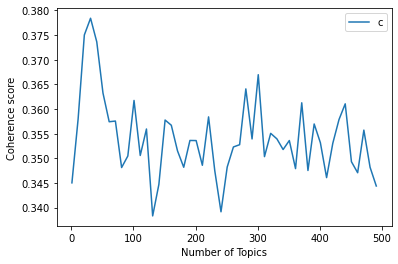

In [69]:
# evaluate a good number of topics for the LSI Model. This takes some time.

if True:

  start, stop, step = 1, 500, 10
  plot_graph(data, start, stop, step)

For unigrams, the best number of topics seems to be around 20.

# Doc2Vec

In [43]:
def get_tagged_documents(corpus):
  for i, tokens in enumerate(corpus):
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i, f'titleid_{sectionid_to_titleid[i]}'])
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])  # diatonic chord distance is a bit better

In [44]:
train_corpus = list(get_tagged_documents(processed_corpus))
train_corpus[1000]

TaggedDocument(words=['C', 'Am', 'Dm', 'G7', 'Em', 'Am', 'Dm', 'G7', 'Gm', 'C7', 'F', 'Bb7', 'Am', 'D7', 'Dm', 'G7'], tags=[500, 'titleid_160'])

In [45]:
import multiprocessing

common_kwargs = dict(
    epochs=40, 
    min_count=1,
    workers=multiprocessing.cpu_count(), 
    negative=10, 
)

print(f"CPU Count: {multiprocessing.cpu_count()}")

dm = 0 # PV-DBOW
dm = 1 # PV-DM
sample = 0.001  # huge influence; 0.001 is best for a high value in the similarity of diatonic chords of the Cmaj scale
window = 2  # 2 is best for diatonic chords
negative = 10 # 10 is best for diatonic chords

model = Doc2Vec(train_corpus,
                dm=1, 
                vector_size=100, 
                window=window, 
                epochs=40,
                workers=1,
                min_count=1,
                negative=negative,
                sample=sample,
                seed=42,
                )

2021-11-20 13:36:59,040 : INFO : collecting all words and their counts
2021-11-20 13:36:59,042 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-20 13:36:59,094 : INFO : PROGRESS: at example #10000, processed 149208 words (2952080/s), 72 word types, 1619 tags
2021-11-20 13:36:59,113 : INFO : collected 72 word types and 7215 unique tags from a corpus of 10806 examples and 165580 words
2021-11-20 13:36:59,114 : INFO : Creating a fresh vocabulary
2021-11-20 13:36:59,119 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 72 unique words (100.0%% of original 72, drops 0)', 'datetime': '2021-11-20T13:36:59.119603', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-20 13:36:59,121 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 165580 word corpus (100.0%% of original 165580, drops 0

CPU Count: 2


2021-11-20 13:36:59,668 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 13:36:59,670 : INFO : EPOCH - 1 : training on 165580 raw words (53265 effective words) took 0.5s, 105059 effective words/s
2021-11-20 13:37:00,184 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 13:37:00,185 : INFO : EPOCH - 2 : training on 165580 raw words (53222 effective words) took 0.5s, 104999 effective words/s
2021-11-20 13:37:00,708 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 13:37:00,710 : INFO : EPOCH - 3 : training on 165580 raw words (53152 effective words) took 0.5s, 104222 effective words/s
2021-11-20 13:37:01,237 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 13:37:01,239 : INFO : EPOCH - 4 : training on 165580 raw words (53217 effective words) took 0.5s, 102173 effective words/s
2021-11-20 13:37:01,738 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-2

### Test the distance between C and the diatonic chords

Test if the model can capture that the diatonic chords are closer to the root.

Do this only if the input corpus contains the unigrams. 

In [46]:
test_tokens = ['C',
              'Dm',
              'Em',
              'F',
              'G7',
              'Am',
              'Bm7b5',
              'F7',
              'D7',
              'A7',
              'E7',
              'B7',
              'F#7',
               'Cm',
               'D']

if 1 in ngrams_for_input:
  ref = 'C'
  for t in test_tokens:
    print(f"{model.wv.similarity(ref, t):.3f}: {ref} <-> {t}")

1.000: C <-> C
0.746: C <-> Dm
0.594: C <-> Em
0.578: C <-> F
0.629: C <-> G7
0.632: C <-> Am
0.588: C <-> Bm7b5
0.463: C <-> F7
0.598: C <-> D7
0.732: C <-> A7
0.678: C <-> E7
0.597: C <-> B7
0.247: C <-> F#7
0.449: C <-> Cm
0.428: C <-> D


In [47]:
if 1 in ngrams_for_input:
  model.wv.similar_by_word('C', topn=20)

Plot the generated word vectors in 2D space

In [48]:
from sklearn.manifold import TSNE

# input data: vectors for all tokens
weights = model.wv.vectors

# only do this when the vocabulary is not too big....
if len(weights) < 100:

  # do T-SNE
  tsne = TSNE(n_components=2, 
              random_state=42,
              perplexity=30,
              learning_rate='auto',
              init='pca',
              n_iter=2000
              )
  T = tsne.fit_transform(weights)

  # plot
  projected = pd.DataFrame(T)

  fig = px.scatter(
      projected, 
      x=0, y=1,
      #color='mode',
      text=model.wv.index_to_key,
      width=800, height=600,
      title="T-SNE applied to Chord Vectors for Tunes in Cmaj/Amin"
  )
  fig.update_traces(textposition='top center')
  fig.update_traces(textfont_size=12, selector=dict(type='scatter'))
  fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



### Test for single tunes

In [49]:
len(sectionid_to_section)

5403

In [50]:
len(model.dv)

7215

In [51]:
title_to_sectionid['These Foolish Things']

[3866, 3867, 3868, 3869]

In [52]:
section_key = 3868

In [53]:
model.dv.similar_by_key(section_key, topn=20)

[(1889, 0.8104585409164429),
 (2760, 0.7966096997261047),
 (1166, 0.7420021891593933),
 (1283, 0.7402357459068298),
 (1511, 0.7371323108673096),
 (5136, 0.7291520237922668),
 (3296, 0.7258016467094421),
 (3595, 0.7229234576225281),
 (5316, 0.7193516492843628),
 ('titleid_1170', 0.710716962814331),
 (5011, 0.7084869146347046),
 (1514, 0.7073755860328674),
 (1906, 0.7019268870353699),
 ('titleid_464', 0.699430525302887),
 (51, 0.6843920946121216),
 (311, 0.6798987984657288),
 (4799, 0.6794383525848389),
 (3875, 0.6720521450042725),
 (3234, 0.6661337614059448),
 ('titleid_1244', 0.665622889995575)]

In [54]:
sectionid_to_section[1889]

"I've Told Eve'ry Little Star, section3 (B)"

In [55]:
titles.query('title == "These Foolish Things"')

,id,tune_id,section_id,section_name,title,tune_mode
3866,3866,1170,1,A,These Foolish Things,major
3867,3867,1170,2,A,These Foolish Things,major
3868,3868,1170,3,B,These Foolish Things,major
3869,3869,1170,4,A,These Foolish Things,major


In [56]:
tune_key = 'titleid_1170'

In [57]:
model.dv.similar_by_key(tune_key, topn=20)

[('titleid_616', 0.7653118968009949),
 (3867, 0.7396513819694519),
 ('titleid_520', 0.7178188562393188),
 (1889, 0.7116326689720154),
 (3868, 0.7107169032096863),
 (1698, 0.6806668043136597),
 ('titleid_1240', 0.6595369577407837),
 (2031, 0.6540782451629639),
 (1511, 0.6465381383895874),
 (2033, 0.6448988318443298),
 ('titleid_521', 0.6437559723854065),
 ('titleid_1334', 0.6411613821983337),
 (311, 0.6371945142745972),
 (1166, 0.6207894086837769),
 ('titleid_164', 0.6198546886444092),
 ('titleid_1517', 0.6185333132743835),
 (4347, 0.6144623160362244),
 (1514, 0.6139699220657349),
 (3796, 0.613869845867157),
 (3282, 0.6052935123443604)]

In [58]:
titles.iloc[755]

id                                           755
tune_id                                      234
section_id                                     5
section_name                                   D
title           Chega De Saudade (No More Blues)
tune_mode                                  minor
Name: 755, dtype: object

#### Section Similarity


In [59]:
def get_section_scores_doc2vec(tunes):

    df_sim = pd.DataFrame(columns=['reference_title',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          # sections are tagged with the numeric sectionid and can be used for querying
          sims = model.dv.similar_by_key(s1, topn=40)
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
              if type(s2) == int:  # only consider similarities to sectionids; tuneids are strings
                  # don't count self-similarity between sections of the same tune
                  if s2 not in title_to_sectionid[tune]:
                      n += 1
                  
                      # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                      df_sim.loc[len(df_sim)] = [tune,
                                      sectionid_to_title[s2],
                                      sectionid_to_section[s1], 
                                      sectionid_to_section[s2], 
                                      s2_score, 
                                      ]
    return df_sim

In [60]:
df_section_sim = get_section_scores_doc2vec(tunes_eval_list)


--------------------------------------------------
3752 Sweet Sue, Just You, section1 (A)
3753 Sweet Sue, Just You, section2 (A)
3754 Sweet Sue, Just You, section3 (B)
3755 Sweet Sue, Just You, section4 (A)

--------------------------------------------------
3866 These Foolish Things, section1 (A)
3867 These Foolish Things, section2 (A)
3868 These Foolish Things, section3 (B)
3869 These Foolish Things, section4 (A)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

-----------

In [61]:
#df_section_sim.head(50)

In [62]:
import plotly.express as px
fig = px.histogram(df_section_sim, x="score", nbins=50, title='Scores for Section Similarities')
fig.show()

In [63]:
result, details = recommend_tune(df_section_sim, 'Perdido')
result.head(30)

,score,max,score_div_max
similar_title,,,
My Little Suede Shoes,0.955599,0.981426,1.000000
Scrapple From The Apple,0.989866,0.989866,1.000000
Jeannie's Song,0.981426,0.981426,1.000000
Two Not One,0.989031,0.989866,0.999156
Thriving From A Riff,0.986976,0.989866,0.997080
Rhythm-a-ning,0.985842,0.989866,0.995935
Shaw 'Nuff,0.983599,0.989866,0.993668
No Moe,0.982867,0.989866,0.992929
Oleo,0.981651,0.989866,0.991701


#### Document Similarity


The TitleId is tagged with the prefix `title_id`, so that it can be distinguished from the sectionid tags, which are numeric.

In [64]:
tunes_eval_list

['Sweet Sue, Just You',
 'These Foolish Things',
 'Blue Moon',
 'All Of Me',
 "All God's Chillun Got Rhythm",
 'I Got Rhythm',
 'Bye Bye Blackbird',
 'Old Fashioned Love',
 'Dinah',
 'Honeysuckle Rose',
 'Misty',
 "We'll Be Together Again",
 'East Of The Sun',
 'Sophisticated Lady',
 'Perdido']

In [65]:
# convert titles to titleid; if multiple tunes with same title, takes the first one. 
titleid_eval = []
for title in tunes_eval_list:
  titleid_eval.append(titles.query(f'title == "{title}"').reset_index().loc[0,'tune_id'])
titleid_eval

[1138, 1170, 159, 60, 57, 505, 206, 1642, 308, 472, 807, 1259, 341, 1082, 951]

In [66]:
for titleid in titleid_eval:
  print()
  print(titleid_to_title[titleid])
  sims = model.dv.similar_by_key(f'titleid_{titleid}', topn=30)
  for key, value in sims:
    if type(key) == str:  # only display document similarities, skip all section similarities
      print(f"{value:.3f} {titleid_to_title[int(key.replace('titleid_', ''))]}")



Sweet Sue, Just You
0.952 Sweet Sue
0.900 I Want To Be Happy
0.884 New York, New York
0.867 Valse Hot
0.837 Avalon

These Foolish Things
0.765 Isn't It A Pity
0.718 I Loves You Porgy
0.660 Very Thought Of You, The
0.644 I May Be Wrong
0.641 You're The Top
0.620 Blue Turning Grey Over You
0.619 Hundred Years From Today, A
0.604 Woody'n You
0.595 They Can't Take That Away From Me
0.593 Eiderdown
0.585 Apple Blossom Time
0.579 Look To The Rainbow
0.579 It Might As Well Be Spring

Blue Moon
0.737 Friday The 13th
0.663 Sleepy Time Gal
0.654 It's You Or No One
0.647 Blue Daniel
0.646 C.T.A.
0.630 All Through The Day
0.623 African Queen, The
0.618 I Mean You

All Of Me
0.809 I'll Be Seeing You
0.785 Shine
0.763 Tempus Fugit

All God's Chillun Got Rhythm
0.917 But Beautiful
0.890 Let's Get Lost
0.850 Lullaby Of Birdland
0.806 Teach Me Tonight
0.801 Cry Me A River
0.800 Besame Mucho
0.799 Too Young To Go Steady
0.796 Come Back To Me
0.790 I'm Getting Sentimental Over You
0.788 I've Got My Love